# Exploring Cook County Housing Prices

## Overview

This project explores what can be learned from an extensive housing dataset that is embedded in a dense social context in Cook County, Illinois.
I conduct some Exploratory Data Analysis (EDA) to understand the structure of the data, understand the correlations between features, and conduct data cleaning. 
Later on, I build a linear model to predict house prices based on a set of features, and I analyze the accuracy/error margins of my project. 

In [42]:
import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Data

The dataset consists of over 500,000 records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total; the 62nd is sales price, which you will predict with linear regression in the next part of this project. An explanation of each variable can be found in the included `codebook.txt` file. Some of the columns have been filtered out to ensure this assignment doesn't become overly long when dealing with data cleaning and formatting.

The data are split into training and test sets with 204,792 and 68,264 observations, respectively, but we will only be working on the training set for this part of the project.

Let's first extract the data from the `cook_county_data.zip`. Notice we didn't leave the `csv` files directly in the directory because they take up too much space without some prior compression.

In [43]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

In [44]:
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

In [45]:
# 204,792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values

Let's look at the features of our training dataset.

In [46]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

In [47]:
training_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

In [48]:
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size
0,17294100610000,203,50,2500.0,76,0.0,2.0,1.0,1.0,3.0,...,9,2,1.0,13.2,0,0.0,50,7650,"This property, sold on 09/14/2015, is a one-st...",2500.0
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,5,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,2,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,7,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,6,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0


<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Contextualizing the Data

Each row of this dataset represents a a house sold in Cook County and has 61 features-- information/data points regarding each house sold. The granularity of this dataset is very fine, because each row represents exactly one house sold in Cook County, which is the region we are focusing on. 

Home sales data is incredibly important for evaluating the health of the economy and understanding the size/type of houses most people are able to buy in particular area. This information can be used to predict the socioeconomic background of certain homeowners and regions, which can help us better understand their financial priorities, tax bracket, etc. and job prospects in the surrounding areas. 

It is likely collected by real estate agencies that have to report transfer of land and homeownership to other people, builders/construction companies, various government agencies, and the Federal Bank. Other companies like Zillow, Apartments.com, etc. that showcase real estate property value online can also use this data to help future homewoners and sellers determine market price and aggregate all of this information together for more people.

The "Modeling Group" variable can tell us a lot of information about the buyer. Most nuclear families will buy a single-family home while most young people may buy condos or something smaller. Wealthier people are more likely to buy multi-family homes, or in collaboration with multiple family members. 

Similarly, the lot size can dictate a lot about the property value in terms of pure square footage, and we can connect the town code to other datasets that tell us about the average and median income, unemployment rates, education level, racial and ethnic demographic, and immigration status of people living in the same area. These are strong indicators of the socioeconomic background of buyers and sellers, and how this affects the property value. 

I would create a violin plot of the lot size for each town code to better understand the distribution of the size of properties sold in a particular area, and how some areas may typically see larger or smaller homes that others. I would imagine that rural areas typically sell larger homes while urban areas sell smaller homes. I would use a violin plot rather than a box plot to see the curves in the distribution that are often ommitted from the box plot, and would not use a regular histogram because we are comparing multiple distributions. 

<!-- END QUESTION -->

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Exploratory Data Analysis

This dataset was collected by the [Cook County Assessor's Office](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) in order to build a model to predict the monetary value of a home (if you didn't put this for your answer for Question 1 Part 2, please don't go back and change it - we wanted speculation!). You can read more about data collection in the CCAO’s [Residential Data Integrity Preliminary Report](https://gitlab.com/ccao-data-science---modeling/ccao_sf_cama_dev/-/blob/master/documentation/Preliminary%20Report%20on%20Data%20Integrity%20June%207,%202019.pdf). 

Here, I will build a linear regression model that predicts sales prices using training data but it's important to first understand how the structure of the data informs such a model. As such, I make a series of exploratory visualizations and feature engineering in preparation for that prediction task.

### Sale Price
I begin by examining the distribution of our target variable `SalePrice`. At the same time, I also take a look at some descriptive statistics of this variable. The helper method `plot_distribution` visualizes the distribution of the `SalePrice` using both the histogram and the box plot at the same time.

In [49]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

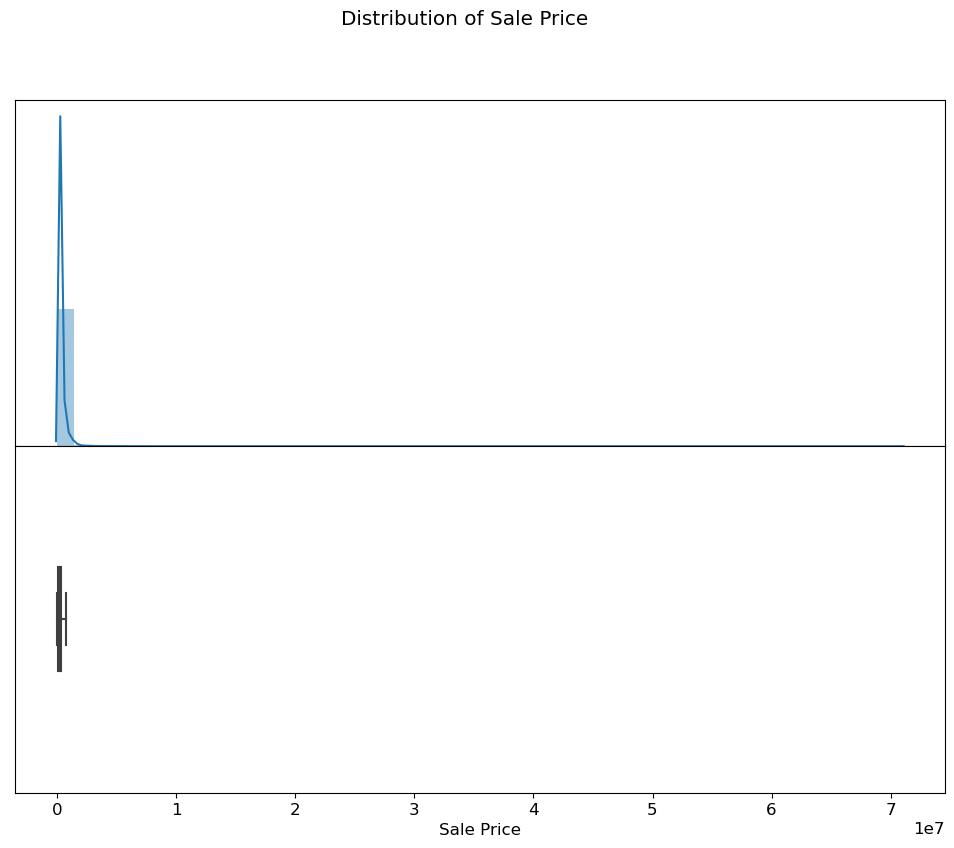

In [50]:
plot_distribution(training_data, label='Sale Price')

<!-- BEGIN QUESTION -->

<br><br>

---
## Improving Data Visualizations

Clearly, this is a terrible visualization because we cannot see any details in the distribution. We can overcome it but adjusting the x-axis range so that we can "zoom into" the distribution. However, doing so can prevent us from seeing outlier values. As such, according to the Tukey-Mostellar Diagram, we can apply the log function to linearize the values better.

<!-- END QUESTION -->



In [51]:
training_data['Sale Price'].describe()

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

<br><br>

---
## Log Transforming the Data

Let's narrow the scope of households by viewing only homes with Sales Prices greater than $500 and log transform the Sales Price to "zoom" into the visualization above.


In [ ]:
training_data = training_data[training_data['Sale Price'] >= 500]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])

Let's create a new distribution plot on the log-transformed sale price.

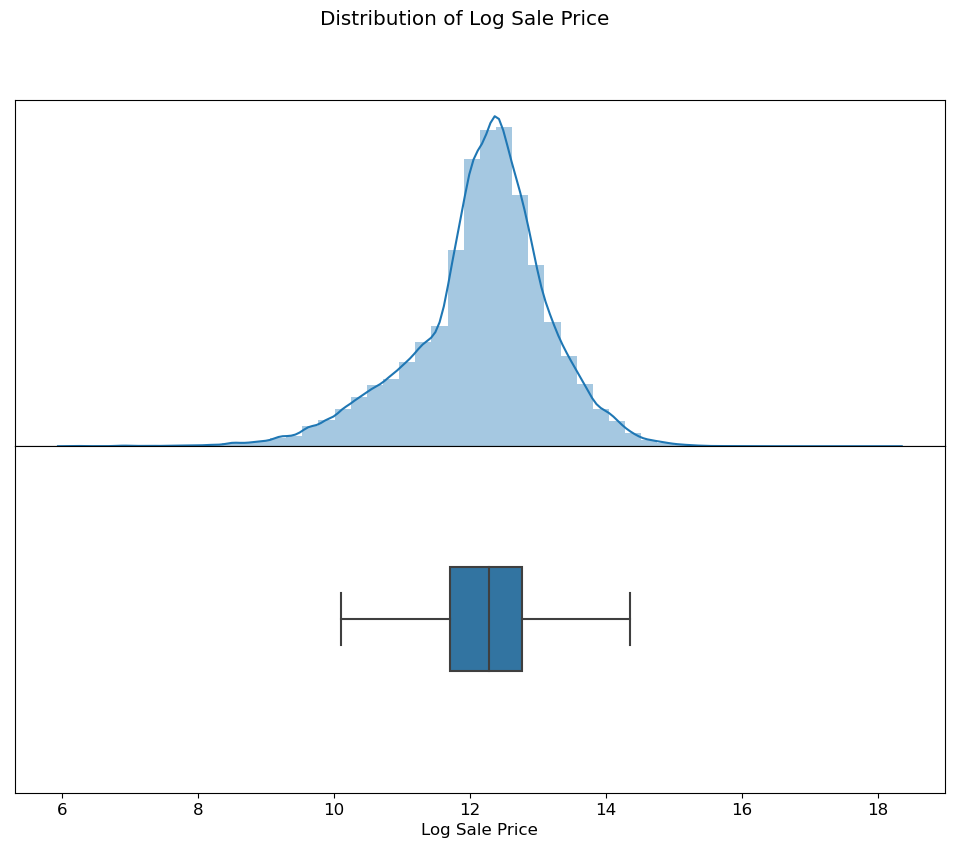

In [54]:
plot_distribution(training_data, label='Log Sale Price')

<br><br>

---

At least 25% of the houses in the training set sold for more than $200,000.00.


<br><br>

---
## Log Sale Price vs Building Square Feet

Let's explore potential correlations between `Log Sale Price` and `Log Building Square Feet`.

Log Building square Feet would be a good candidate for a feature in our model because it has a relatively linear scatterplot, and the distribution of it's values has a similar shape to the distribution of the Log Sale Price. This could mean that there is a relationship between the two that we can furhter explore. On top of that, from a simple observational and practical standpoint, the amount of space one gets is a major factor in how much one is willing to spend on a property. 


In [57]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

<!-- END QUESTION -->

<br><br>

---
## Handling Outliers

Let's remove outliers based on Building Square Feet less than or equal to 8000.

In [59]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a DataFrame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[(data[variable] <= upper) & (data[variable] > lower)]

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 3: Feature Engineering


### Bedrooms

Let's start simple by extracting the total number of bedrooms as our first feature for the model. Since this is not a explicit column in the dataframe, we must extract it from the `Description` column. To understand this, I explore what a typical `Description` column looks like.

<br><br>

---

In [ ]:
training_data['Description'][238]

'This property, sold on 11/13/2015, is a one-story houeshold located at 1485 MEEGAN WAY.It has a total of 6 rooms, 3 of which are bedrooms, and 2.0 of which are bathrooms.'

<br><br>

---
## Adding the "Bedrooms" Column

This function extracts the number of bedrooms from the `Description` column and adds this integer value as a separate colun in the dataframe. 

In [64]:
def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.
    """
    import re
    with_rooms = data.copy()
    pattern = r"\b(\d+)\s+of\s+which\s+are\s+bedrooms\b"
    
    #with_rooms['Bedrooms'] = with_rooms['Description'].str.findall(r"\b(\d+)\s+of\s+which\s+are\s+bedrooms\b")
    with_rooms['Bedrooms'] = with_rooms['Description'].apply(lambda x: re.findall(pattern, x)).apply(lambda x: x[0]).astype(int)
        # need a lambda function to pares over all of the values in the Description series
        # need to assert that the string we extracted is converted into an int
    
    with_rooms['Bedrooms'].fillna(0)
    return with_rooms

training_data = add_total_bedrooms(training_data)
training_data['Bedrooms'][3]

3

<!-- BEGIN QUESTION -->

<br><br>

---
## Visualizing Bedrooms vs Log Sale Price

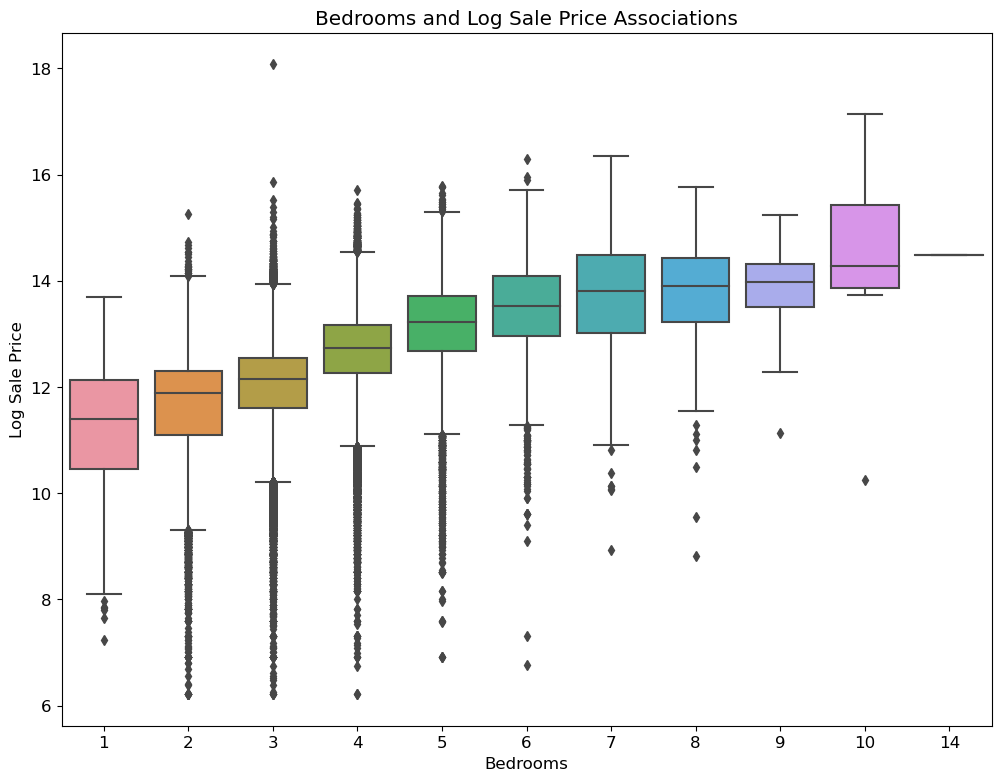

In [66]:
sns.boxplot(data=training_data, x='Bedrooms', y='Log Sale Price')
plt.title('Bedrooms and Log Sale Price Associations')
plt.show()

<br><br>

---
## Neighborhoods and Neighborhood Codes

It's possible that there is a correlation between neighborhoods and neighborhood codes. Let's find the number of unique neighborhoods. 

In [67]:
num_neighborhoods = training_data['Neighborhood Code'].nunique()
num_neighborhoods

193

<br><br>

---
## Handling Overplotting

In [69]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

Since there are **many** neighborhoods in our dataset, we are running into an overplotting error. Let's reduce density for clarity by 
assigning the variable `in_top_20_neighborhoods` to a copy of `training_data` that contains only top 20 neighborhoods with the most number of houses.


In [70]:
popular_neighborhoods = training_data['Neighborhood Code'].value_counts()[:20]
    # getting a list of the 20 most frequently occurring unique neighborhood codes
    # now use this list to do boolean sorting for training_data to get the rows that contain any of these Neighborhood Codes

#in_top_20_neighborhoods = training_data[training_data['Neighborhood Code'].isin(popular_neighborhoods)]

in_top_20_neighborhoods = training_data[training_data['Neighborhood Code'].apply(lambda x: x in popular_neighborhoods)]

# double checkign my sorting work
# neighborhood codes and counts match up exactly
#print(popular_neighborhoods,"\n")
#in_top_20_neighborhoods['Neighborhood Code'].value_counts()

# length of unique neighborhood matches
#print(len(popular_neighborhoods))
#print(len(in_top_20_neighborhoods['Neighborhood Code'].value_counts()))

Let's create another of the distribution of sale price within in each neighborhood again, but this time with a narrower focus!

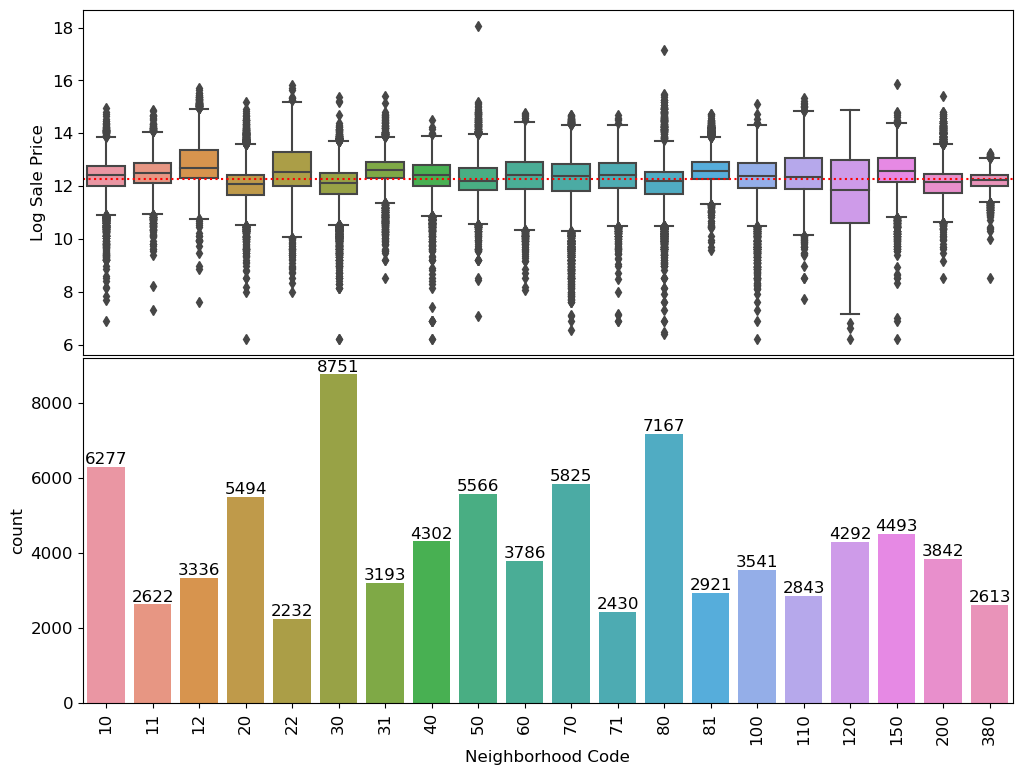

In [72]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

The median Log Sale Price across the 20 most popular neighborhoods is roughly the same. Some neighborhoods have a much tighter middle 50% of sales, like neighborhood 31, while others are much broader, like nieghborhood 120. Some neighborhoods have a much higher absolute max while others have a much lower absolute minimum. This visualization doesn't tell us anything about the average, but we can see that the median is roughly within 1 (or even less than 1) log sale price unit across all 20 most popular neighborhoods. 

<!-- END QUESTION -->

<br><br>

---
## Binning Neighborhoods
Let's bin some neighborhood codes together to better evaluate the potential correlations between `Log Sale Price` and the `n` most pricy neighborhoods.


In [73]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (DataFrame): should contain at least a string-valued 'Neighborhood Code'
        and a numeric 'Log Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods 
      as measured by the metric function
    """
    
    # find the neighborhood codes for neighborhoods with the highest median Log Sale Price
    
    neighborhoods = data.groupby('Neighborhood Code').agg(metric).sort_values(by=['Log Sale Price'], ascending=False).reset_index()['Neighborhood Code'][:n]
    #display(neighborhoods)
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

<br><br>

---
## Pricy Neighborhood Boolean Flags

Let's add a booleon flag column to indiciate if a specific house/row is a pricy neighborhood or not.

In [75]:
def add_in_expensive_neighborhood(data, neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(neighborhoods).astype(bool)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)
# training_data[training_data['Neighborhood Code']==94]

<br><br>

---
## Roof Material

```
Central Heating (Nominal): 

       1	Shingle/Asphalt
       2	Tar&Gravel
       3	Slate
       4	Shake
       5    Tile
       6    Other
```

The function `substitute_roof_material` replaces each numerical value in `Roof Material` with their corresponding roof material.


In [77]:
def substitute_roof_material(data):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      DataFrame identical to the input except with a refactored 'Roof Material' column
    """
    #data_copy = data.copy()
    #display(data)
    
    data['Roof Material'] = data['Roof Material'].replace({1: 'Shingle/Asphalt', 2: 'Tar&Gravel', 3: 'Slate', 4: 'Shake', 5: 'Tile', 6: 'Other'})
    
    # DO NOT make a copy this way, it crashes everything when re-parsing stuff
    #data_copy = data['Roof Material'].replace(1, 'Shingle/Asphalt', inplace=False)
    #data_copy = data['Roof Material'].replace(2, 'Shingle/Asphalt', inplace=False)
    #data_copy = data['Roof Material'].replace(3, 'Slate', inplace=False)
    #data_copy = data['Roof Material'].replace(4, 'Shake', inplace=False)
    #data_copy = data['Roof Material'].replace(5, 'Tile', inplace=False)
    #data_copy = data['Roof Material'].replace(6, 'Other', inplace=False)

    
    #data_copy = data['Roof Material']
    #data_copy.replace({1: 'Shingle/Asphalt', 2: 'Tar&Gravel', 3: 'Slate', 4: 'Shake', 5: 'Tile', 6: 'Other'})
    
    #rf_mat_copy = data_copy['Roof Material']
    #rf_mat_copy.replace('1.0', 'Shingle/Asphalt')
    
    return data
    
training_data = substitute_roof_material(training_data)
training_data

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3,False
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,3,False
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,3,False
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2,False
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204787,25163010260000,202,321,4375.0,72,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,321,72321,"This property, sold on 07/23/2014, is a one-st...",4375.0,10.521372,6.813445,2,False
204788,5063010090000,204,21,16509.0,23,0.0,1.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,21,2321,"This property, sold on 03/27/2019, is a one-st...",16509.0,12.323856,7.603399,4,False
204789,16333020150000,202,90,3810.0,15,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,90,1590,"This property, sold on 01/31/2014, is a one-st...",3810.0,11.813030,6.815640,3,False
204790,9242030500000,203,80,6650.0,22,0.0,2.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,80,2280,"This property, sold on 02/22/2018, is a one-st...",6650.0,12.879017,7.092574,3,False


<br><br>

---
## One Hot Encoding

We must one-hot-encode the `Roof Material` column because it is a categorical variable.

In [109]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """    
    data_copy = data
    oh_enc = OneHotEncoder()
    #catagories = training_data['Roof Material'].value_counts().reset_index()['index']
    catagories = ['Shingle/Asphalt','Tar&Gravel','Slate','Shake','Tile','Other']
    
    oh_enc.fit(data[['Roof Material']])
    catagories_data = oh_enc.transform(data[['Roof Material']]).toarray()
    catagories_df = pd.DataFrame(data=catagories_data, columns=oh_enc.get_feature_names_out(), index=data.index)
    
    return data_copy.join(catagories_df)


training_data_ohe = ohe_roof_material(training_data)
# Return columns with name that starts with "Roof Material_" 
training_data_ohe.filter(regex='^Roof Material_').head(10)

,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar&Gravel,Roof Material_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0


# Predicting Housing Prices in Cook County

In [ ]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training/validation and test data. The dataset was split into a testing and training set.

In [ ]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values